In [25]:
import pandas as pd

import numpy as np
from numpy import unique

import matplotlib.pyplot as plt
%matplotlib inline

from keras.layers import Input, Dense
from keras.models import Model
from keras.utils import plot_model
from keras.layers import Input, Embedding, Flatten, Subtract

from sklearn.model_selection import train_test_split


In [2]:
input_tensor = Input(shape=(1,))
output_tensor = Dense(1)(input_tensor)
model = Model(input_tensor, output_tensor)
model.compile(optimizer='adam', loss='mean_absolute_error')
model.summary()

Instructions for updating:
Colocations handled automatically by placer.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 1)                 0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 2         
Total params: 2
Trainable params: 2
Non-trainable params: 0
_________________________________________________________________


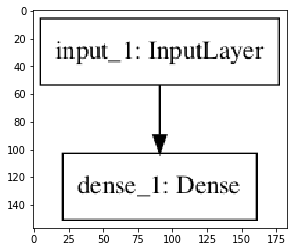

In [3]:
plot_model(model, to_file='model.png')
data = plt.imread('model.png')
plt.imshow(data)
plt.show()

In [7]:
games_tourney = pd.read_csv('basketball_data/games_tourney.csv')
games_tourney.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4234 entries, 0 to 4233
Data columns (total 9 columns):
season        4234 non-null int64
team_1        4234 non-null int64
team_2        4234 non-null int64
home          4234 non-null int64
seed_diff     4234 non-null int64
score_diff    4234 non-null int64
score_1       4234 non-null int64
score_2       4234 non-null int64
won           4234 non-null int64
dtypes: int64(9)
memory usage: 297.8 KB


In [11]:
games_tourney_train = games_tourney[:3430]
games_tourney_test = games_tourney[3430:]

In [12]:
games_tourney_train.tail()

,season,team_1,team_2,home,seed_diff,score_diff,score_1,score_2,won
3425,2011,667,10690,0,-9,-14,58,72,0
3426,2011,1039,10690,0,-4,7,61,54,1
3427,2011,4209,10690,0,-1,-5,65,70,0
3428,2011,1073,10713,0,11,8,74,66,1
3429,2011,4899,10812,0,-5,11,66,55,1


In [13]:
games_tourney_test.head()

,season,team_1,team_2,home,seed_diff,score_diff,score_1,score_2,won
3430,2012,1907,100,0,1,1,58,57,1
3431,2012,1704,649,0,-8,-17,63,80,0
3432,2012,4291,649,0,2,12,82,70,1
3433,2012,7533,649,0,-11,-8,60,68,0
3434,2012,10813,649,0,-7,-5,70,75,0


In [14]:
model.fit(games_tourney_train.seed_diff, games_tourney_train.score_diff, epochs=1, 
          batch_size=128, validation_split=0.1, verbose=True)

Instructions for updating:
Use tf.cast instead.
Train on 3087 samples, validate on 343 samples
Epoch 1/1
3087/3087 [==============================] - 1s 232us/step - loss: 9.1908 - val_loss: 8.5040


In [15]:
model.evaluate(games_tourney_test.seed_diff, games_tourney_test.score_diff)

804/804 [==============================] - 0s 26us/step


9.343884653119899

In [17]:
games_season = pd.read_csv('basketball_data/games_season.csv')
games_season.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 312178 entries, 0 to 312177
Data columns (total 8 columns):
season        312178 non-null int64
team_1        312178 non-null int64
team_2        312178 non-null int64
home          312178 non-null int64
score_diff    312178 non-null int64
score_1       312178 non-null int64
score_2       312178 non-null int64
won           312178 non-null int64
dtypes: int64(8)
memory usage: 19.1 MB


In [28]:
n_teams = unique(games_season.team_1).shape[0]
n_teams

10888

In [20]:
team_lookup = Embedding(input_dim=n_teams, output_dim=1, input_length=1, 
                        name='Team-Strength')

In [22]:
teamid_in = Input(shape=(1, ))
strength_lookup = team_lookup(teamid_in)
strength_lookup_flat = Flatten()(strength_lookup)
team_strength_model = Model(teamid_in, strength_lookup_flat, 
                            name='Team-Strength-Model')


In [23]:
team_in_1 = Input(shape=(1, ), name='Team-1-In')
team_in_2 = Input(shape=(1, ), name='Team-2-In')

In [24]:
team_1_strength = team_strength_model(team_in_1)
team_2_strength = team_strength_model(team_in_2)

In [27]:
score_diff = Subtract()([team_1_strength, team_2_strength])
model = Model([team_in_1, team_in_2], score_diff)
model.compile('adam', 'mean_absolute_error')

In [29]:
input_1 = games_season.team_1
input_2 = games_season.team_2
model.fit([input_1, input_2], games_season['score_diff'], epochs=1, batch_size=2048,
          validation_split=0.1, verbose=True)

Train on 280960 samples, validate on 31218 samples
Epoch 1/1
280960/280960 [==============================] - 2s 8us/step - loss: 12.1202 - val_loss: 11.8383


In [30]:
input_1 = games_tourney.team_1
input_2 = games_tourney.team_2
model.evaluate([input_1, input_2], games_tourney.score_diff)

4234/4234 [==============================] - 0s 35us/step


11.680995766824859